# Install the required libraries

In [1]:
!apt install -y enchant-2
%pip install pyenchant

# Data Processing

In [1]:
import re
import enchant
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

df = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', delimiter='\t')
# df = pd.read_csv('test.tsv', delimiter='\t')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liqing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/liqing/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/liqing/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:

wnl = WordNetLemmatizer()
USdict = enchant.Dict("en_US")
stoplist = set(stopwords.words('english'))
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)


def clean_and_tokenize(text):
    """
    Clean the text, remove non-English text, and then perform word segmentation and part-of-speech restoration.
    """
    text = re.sub(r'@[\w]*', '', text)  # Remove the username
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)  # Remove URL
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)  # Remove punctuation
    text = text.lower().strip()  # Convert to lowercase and remove spaces at the beginning and end

    # Determine whether it is English text.
    if not all(ord(c) < 128 for c in text):
        return None

    # Participle
    words = tknzr.tokenize(text.replace('.', ' '))
    words = [word for word in words if USdict.check(word) and word.isalpha() and len(word) > 2]

    # Part of speech reduction
    def get_wordnet_pos(tag):
        """Obtain WordNet's part-of-speek annotations according to NLTK annotations"""
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  # Default to noun

    tagged_words = pos_tag(words)
    lemmatized_words = [wnl.lemmatize(tag[0], pos=get_wordnet_pos(tag[1])) for tag in tagged_words]

    filtered_words = [word for word in lemmatized_words if word not in stoplist]
    resulting_string = ' '.join(filtered_words)
    return resulting_string


# Apply cleaning and word segmentation functions to the entire data set
df['cleaned_tweet_words'] = df['tweet_text'].apply(clean_and_tokenize)
df.dropna(subset=['cleaned_tweet_words'], inplace=True)
df.head(5)

,sentiment_label,tweet_text,cleaned_tweet_words
0,4,"@elephantbird Hey dear, Happy Friday to You A...",hey dear happy already rice bowl lunch
1,4,Ughhh layin downnnn Waiting for zeina to co...,wait cook breakfast
2,0,"@greeniebach I reckon he'll play, even if he's...",reckon hell play even know nothing wont without
3,0,@vaLewee I know! Saw it on the news!,know saw news
4,0,very sad that http://www.fabchannel.com/ has c...,sad close one web service use year


# Run Machine Learning

In [3]:
x = df['cleaned_tweet_words']
y = df['sentiment_label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

bow_vectorizer = CountVectorizer(max_df=0.80, min_df=2)

Traning Accuracy of KNN Classifier:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76     64030
           4       0.75      0.80      0.77     63963

    accuracy                           0.76    127993
   macro avg       0.77      0.76      0.76    127993
weighted avg       0.77      0.76      0.76    127993


Test Accuracy of KNN Classifier:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65     15967
           4       0.66      0.72      0.69     16032

    accuracy                           0.67     31999
   macro avg       0.67      0.67      0.67     31999
weighted avg       0.67      0.67      0.67     31999


Traning Accuracy of Naive Bayes:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     64030
           4       0.77      0.75      0.76     63963

    accuracy                           0.76    127993
   macro avg       0.76 

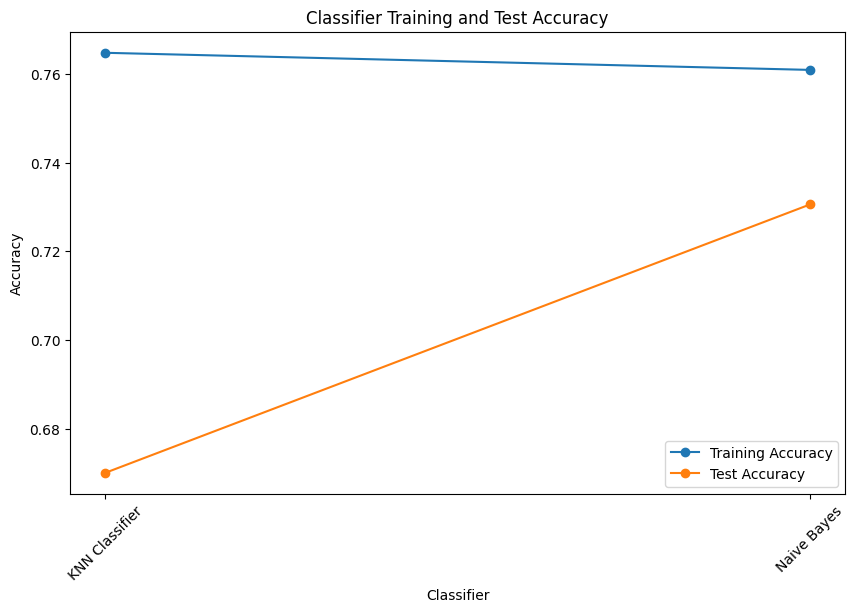

In [4]:

classifiers = {
    "KNN Classifier": KNeighborsClassifier(),
    # "Linear Regrerssion lbfgs": LogisticRegression(solver='lbfgs', max_iter=1000),
    # "Linear Regrerssion saga": LogisticRegression(solver='saga', max_iter=1000),
    # "Linear Regrerssion lbfgs with c = 0.1": LogisticRegression(solver='lbfgs', max_iter=1000, C=0.1),
    # "Random Forest": RandomForestClassifier(),
    # "SVM Classifier": SGDClassifier(loss='hinge'), # SVM
    "Naive Bayes": MultinomialNB()
}

train_accuracies = []
test_accuracies = []
classifiers_names = []

for name, clf in classifiers.items():
    pipe = make_pipeline(bow_vectorizer, clf)
    pipe.fit(x_train, y_train)

    # Calculate the accuracy of training
    train_pred = pipe.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    train_accuracies.append(train_accuracy)
    print(f"Traning Accuracy of {name}:\n{classification_report(y_train, train_pred)}\n")

    # Calculate the accuracy of the test
    test_pred = pipe.predict(x_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_accuracies.append(test_accuracy)

    classifiers_names.append(name)
    print(f"Test Accuracy of {name}:\n{classification_report(y_test, test_pred)}\n")

# Draw a chart
plt.figure(figsize=(10, 6))
plt.plot(classifiers_names, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(classifiers_names, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Training and Test Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.show()
